In [1]:
import os.path as osp
import GPUtil
import torch.nn as nn
import torch

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
import pandas as pd
from performance import performances_val
from PIL import Image
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.data import Data
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import ChebConv, GraphSAGE,GraphUNet ,TransformerConv

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed = 1378
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
spoof_arr = np.load("spoof.npy")
live_arr = np.load("live.npy")

In [4]:
landmark_colors = np.load("landmark_colors.npy")
from sklearn.preprocessing import OneHotEncoder
one_hot_list=[]
enc = OneHotEncoder()
enc.fit(np.expand_dims(landmark_colors,axis=1))  
for x in landmark_colors:
    one_hot_list.append(enc.transform([[x]]).toarray()[0])
one_hot_arr  = np.array(one_hot_list)
one_hot_arr = torch.FloatTensor(one_hot_arr)

In [5]:
class landmark_dataset(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        list_s = os.path.basename(graph_path).split(".")
        l_f = list_s[0]+"."+list_s[1]
        path_clip_feature = os.path.dirname(graph_path)+"/"+"CLIP_"+l_f+".npy"
        clip_f = torch.tensor(np.load(path_clip_feature))
        
        data = torch.load(graph_path)
        if int(data.y) == 1 :
            
            text_enc = torch.tensor(live_arr)
            data.y = torch.tensor([[1,0]])
        elif int(data.y)==0 :
            
            text_enc = torch.tensor(spoof_arr)
            data.y = torch.tensor([[0,1]])
        #data.x =data.x.t()
        return  Data(x=data.x, edge_index=data.edge_index,y =data.y,
                   clip_f = clip_f,text_enc=text_enc)
 

In [6]:
class landmark_dataset_train(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        data = torch.load(graph_path)
        list_s = os.path.basename(graph_path).split(".")
        l_f = list_s[0]+"."+list_s[1]
        path_clip_feature = os.path.dirname(graph_path)+"/"+"CLIP_"+l_f+".npy"
        
        clip_f = torch.tensor(np.load(path_clip_feature))
        
        domain_name = graph_path.split("/")[-4]
        
            
        if domain_name == "MSU_MFSD" :
            
            domain_label = torch.FloatTensor([[0,0,1]])
            
        elif domain_name == "Replay_attack_dataset" :
            
            domain_label = torch.FloatTensor([[0,1,0]])
            
        elif domain_name == "oulu" :
            
            domain_label = torch.FloatTensor([[0,0,1]])
        else :
            print(graph_path,domain_name )
            raise "error"
        
        if int(data.y) == 1 :
            
            text_enc = torch.tensor(live_arr)
            
            data.y = torch.tensor([[1,0]])
            
        elif int(data.y)==0 :
            
            text_enc = torch.tensor(spoof_arr)
            
            data.y = torch.tensor([[0,1]])
        
        data = Data(x=data.x, edge_index=data.edge_index,y =data.y,data = domain_label,y_node = one_hot_arr,
                   clip_f = clip_f,text_enc =text_enc)

        #data.x =data.x.t()
        return data 

In [7]:
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_O_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=16)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_C.txt")
test_loader = DataLoader(test_dataset, batch_size=64,num_workers=16)


In [8]:
for i in train_loader :
    print(i)
    break

DataBatch(x=[29952, 640], edge_index=[2, 327168], y=[64, 2], data=[64, 3], y_node=[29952, 7], clip_f=[64, 512], text_enc=[64, 512], batch=[29952], ptr=[65])


In [9]:
for i in test_loader :
    print(i)
    break

DataBatch(x=[29952, 640], edge_index=[2, 327168], y=[64, 2], clip_f=[64, 512], text_enc=[64, 512], batch=[29952], ptr=[65])


In [10]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
#sequence_length = 128
#feature_dim = 4  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer(nn.Module):
    def __init__(self,sequense_step,embed_dim, num_layers, nhead, out_dim):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(1, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequense_step * embed_dim, out_dim)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [11]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
sequence_length = 128
feature_dim = 1  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer_2(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead):
        super(SimpleTransformer_2, self).__init__()
        self.linear = nn.Linear(feature_dim, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequence_length * embed_dim, 7)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [11]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(nn.Module):
    def __init__(self, max_iter):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_domain)
        self.ad_net = nn.Sequential(
            self.fc1,
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            self.fc2
        )
        self.grl_layer = GRL(max_iter)

    def forward(self, feature):
        adversarial_out = self.ad_net(self.grl_layer(feature))
        return adversarial_out



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, 1024,2)
        self.conv2 = ChebConv(1024, 1024,2)
        self.conv3 = ChebConv(1024, 1024,2)
        self.conv4 = ChebConv(1024, 1024,2)
        self.conv5 = ChebConv(1024*2, 1024,2)
        self.conv6 = ChebConv(1024, 1024,2)
        self.conv7 = ChebConv(1024, 1024,2)
        self.conv8 = ChebConv(1024, 1024,2)
        self.lin = SimpleTransformer(8,5,8)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(1024)
        self.b2 = BatchNorm(1024)
        self.b3 = BatchNorm(1024)
        self.b4 = BatchNorm(1024)
        self.b5 = BatchNorm(1024)
        self.b6 = BatchNorm(1024)
        self.b7 = BatchNorm(1024)
        
        self.dis = Discriminator(max_iter)
        
#         self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
#         self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
#         self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en):
        
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x_2 = x
        
        x = self.drop_2(x,drop_en)
                
                    
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
                
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,x_2),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        #x = torch.concat((x,clip_f),dim=1)
        #print(x.shape)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        dis_invariant = self.dis(x)
        

        
        return x ,dis_invariant

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
cls_loss = torch.nn.CrossEntropyLoss()
# criterion= nn.BCELoss()
# criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = torch.nn.CrossEntropyLoss()
cos_loss_V = torch.nn.CosineEmbeddingLoss()
cos_loss_T = torch.nn.CosineEmbeddingLoss()

def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_V=0
    total_loss = 0
    losses_loss_T = 0
    losses_loss_cls=0
    cos = torch.nn.CosineSimilarity()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        
        out,dis_invariant = model(graph.x, graph.edge_index, graph.batch,drop_en)  # Perform a single forward pass.
        
        adv_loss = criterion_2(dis_invariant, graph.data)
        
        loss_V = cos_loss_V(out,graph.clip_f,torch.tensor([1.0]).to(device))
        
        loss_T = cos_loss_T(out,graph.text_enc,torch.tensor([1.0]).to(device))
        
        logit_l = torch.unsqueeze(cos(out,torch.tensor(live_arr).to(device)),dim=1)
        logit_s = torch.unsqueeze(cos(out,torch.tensor(spoof_arr).to(device)),dim=1)        

        
        #print(logit_l.shape,logit_s.shape)
        
        logits = torch.cat((logit_l, logit_s), dim=1)
        #print(logits.shape ,graph.y.shape)
        
        loss_cls  = cls_loss(logits,graph.y.float())
        
        
        loss_all = adv_loss + loss_V + loss_T + loss_cls
        
        print(loss_cls)
        print(loss_V)
        
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_V = loss_V + losses_loss_V
        losses_loss_T = loss_T + losses_loss_T
        losses_loss_cls = loss_cls + losses_loss_cls


    print("/////////////////////////")
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("V loss : " , losses_loss_V/len(train_loader.dataset))
    print("T  loss : " , losses_loss_T/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    cos = torch.nn.CosineSimilarity()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
                
            graph = graph.to(device)  # Move data to the device
            embeding,_= model(graph.x, graph.edge_index, graph.batch,graph.clip_f)
            logit_l = torch.unsqueeze(cos(embeding,torch.tensor(live_arr).to(device)),dim=1)
            logit_s = torch.unsqueeze(cos(embeding,torch.tensor(spoof_arr).to(device)),dim=1)
            logit = F.softmax(torch.cat((logit_l, logit_s), dim=1),dim=1)[:,0] 
            live_label = graph.y.float()[:,0]
            #print(live_label.shape)
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test



TypeError: __init__() missing 2 required positional arguments: 'nhead' and 'out_dim'

In [15]:
best_auc = 0
for epoch in range(1, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'V_10_without_pipline_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue  


Epoch 2:   0%|                                                                                                   | 0/3342 [00:00<?, ?batch/s]

tensor(0.6967, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|                                                                                         | 2/3342 [00:02<1:12:11,  1.30s/batch]

tensor(0.6973, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|                                                                                           | 3/3342 [00:03<51:49,  1.07batch/s]

tensor(0.6975, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9405, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6966, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9283, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▏                                                                                          | 5/3342 [00:04<37:14,  1.49batch/s]

tensor(0.6970, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.9000, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▏                                                                                          | 6/3342 [00:04<34:00,  1.63batch/s]

tensor(0.6953, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8764, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▏                                                                                          | 7/3342 [00:05<32:01,  1.74batch/s]

tensor(0.6947, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6937, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8323, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▏                                                                                          | 8/3342 [00:05<30:55,  1.80batch/s]

tensor(0.6927, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.8117, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▎                                                                                         | 10/3342 [00:06<29:16,  1.90batch/s]

tensor(0.6917, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7865, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▎                                                                                         | 11/3342 [00:07<28:58,  1.92batch/s]

tensor(0.6916, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7717, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▎                                                                                         | 12/3342 [00:08<28:49,  1.93batch/s]

tensor(0.6919, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7395, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6910, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7248, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▍                                                                                         | 14/3342 [00:09<28:22,  1.95batch/s]

tensor(0.6900, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.7096, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▍                                                                                         | 15/3342 [00:09<28:16,  1.96batch/s]

tensor(0.6910, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6900, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6901, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6702, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   0%|▍                                                                                         | 16/3342 [00:10<28:23,  1.95batch/s]

tensor(0.6891, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6520, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▍                                                                                         | 17/3342 [00:10<28:47,  1.92batch/s]

tensor(0.6892, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6423, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▍                                                                                         | 18/3342 [00:11<28:40,  1.93batch/s]

tensor(0.6896, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6239, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▌                                                                                         | 19/3342 [00:11<28:44,  1.93batch/s]

tensor(0.6886, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.6015, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▌                                                                                         | 21/3342 [00:12<28:16,  1.96batch/s]

tensor(0.6882, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5960, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▌                                                                                         | 22/3342 [00:13<28:14,  1.96batch/s]

tensor(0.6879, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5853, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6881, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5605, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▌                                                                                         | 23/3342 [00:13<28:20,  1.95batch/s]

tensor(0.6870, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5551, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▋                                                                                         | 25/3342 [00:14<28:18,  1.95batch/s]

tensor(0.6883, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5368, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▋                                                                                         | 26/3342 [00:15<28:05,  1.97batch/s]

tensor(0.6882, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5259, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▋                                                                                         | 27/3342 [00:15<28:06,  1.97batch/s]

tensor(0.6873, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6889, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.5236, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▊                                                                                         | 28/3342 [00:16<28:16,  1.95batch/s]

tensor(0.6868, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4919, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▊                                                                                         | 29/3342 [00:16<28:22,  1.95batch/s]

tensor(0.6876, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4902, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▊                                                                                         | 30/3342 [00:17<28:27,  1.94batch/s]

tensor(0.6864, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4723, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▊                                                                                         | 32/3342 [00:18<28:20,  1.95batch/s]

tensor(0.6856, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6854, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4577, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▉                                                                                         | 33/3342 [00:18<28:26,  1.94batch/s]

tensor(0.6867, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4492, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▉                                                                                         | 35/3342 [00:19<28:07,  1.96batch/s]

tensor(0.6850, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4471, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6857, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4465, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▉                                                                                         | 36/3342 [00:20<28:01,  1.97batch/s]

tensor(0.6850, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4347, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|▉                                                                                         | 37/3342 [00:20<28:01,  1.97batch/s]

tensor(0.6855, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4342, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█                                                                                         | 38/3342 [00:21<28:05,  1.96batch/s]

tensor(0.6822, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4247, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█                                                                                         | 40/3342 [00:22<28:00,  1.96batch/s]

tensor(0.6854, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4364, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6859, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4130, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█                                                                                         | 41/3342 [00:22<28:06,  1.96batch/s]

tensor(0.6837, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4000, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▏                                                                                        | 42/3342 [00:23<28:15,  1.95batch/s]

tensor(0.6852, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4194, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▏                                                                                        | 43/3342 [00:23<28:16,  1.95batch/s]

tensor(0.6843, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4070, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▏                                                                                        | 44/3342 [00:24<28:01,  1.96batch/s]

tensor(0.6835, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4132, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▏                                                                                        | 45/3342 [00:24<28:01,  1.96batch/s]

tensor(0.6811, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3971, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▏                                                                                        | 46/3342 [00:25<28:12,  1.95batch/s]

tensor(0.6829, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4143, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▎                                                                                        | 47/3342 [00:25<28:13,  1.95batch/s]

tensor(0.6814, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4159, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▎                                                                                        | 48/3342 [00:26<28:11,  1.95batch/s]

tensor(0.6817, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4025, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▎                                                                                        | 49/3342 [00:26<28:08,  1.95batch/s]

tensor(0.6840, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4022, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   1%|█▎                                                                                        | 50/3342 [00:27<28:05,  1.95batch/s]

tensor(0.6846, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4012, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▎                                                                                        | 51/3342 [00:27<28:06,  1.95batch/s]

tensor(0.6825, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3969, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▍                                                                                        | 52/3342 [00:28<28:20,  1.94batch/s]

tensor(0.6852, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4030, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▍                                                                                        | 53/3342 [00:29<28:18,  1.94batch/s]

tensor(0.6768, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3925, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▍                                                                                        | 54/3342 [00:29<28:09,  1.95batch/s]

tensor(0.6832, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4193, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▍                                                                                        | 55/3342 [00:30<28:04,  1.95batch/s]

tensor(0.6807, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4246, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▌                                                                                        | 57/3342 [00:31<27:58,  1.96batch/s]

tensor(0.6782, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4148, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6788, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4087, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▌                                                                                        | 58/3342 [00:31<27:57,  1.96batch/s]

tensor(0.6827, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4066, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▌                                                                                        | 59/3342 [00:32<28:02,  1.95batch/s]

tensor(0.6859, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4017, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▌                                                                                        | 60/3342 [00:32<27:57,  1.96batch/s]

tensor(0.6827, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3934, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▋                                                                                        | 61/3342 [00:33<28:00,  1.95batch/s]

tensor(0.6781, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3905, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▋                                                                                        | 62/3342 [00:33<28:18,  1.93batch/s]

tensor(0.6819, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3986, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▋                                                                                        | 64/3342 [00:34<27:53,  1.96batch/s]

tensor(0.6822, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4081, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▊                                                                                        | 65/3342 [00:35<27:45,  1.97batch/s]

tensor(0.6814, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4251, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▊                                                                                        | 66/3342 [00:35<27:43,  1.97batch/s]

tensor(0.6824, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4211, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6822, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4131, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▊                                                                                        | 67/3342 [00:36<27:52,  1.96batch/s]

tensor(0.6804, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4042, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▊                                                                                        | 69/3342 [00:37<27:37,  1.97batch/s]

tensor(0.6820, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6780, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3945, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▉                                                                                        | 70/3342 [00:37<27:46,  1.96batch/s]

tensor(0.6818, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4089, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▉                                                                                        | 72/3342 [00:38<27:34,  1.98batch/s]

tensor(0.6816, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6816, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3967, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|█▉                                                                                        | 73/3342 [00:39<27:38,  1.97batch/s]

tensor(0.6800, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3940, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██                                                                                        | 75/3342 [00:40<27:32,  1.98batch/s]

tensor(0.6808, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4067, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6796, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3933, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██                                                                                        | 76/3342 [00:40<27:35,  1.97batch/s]

tensor(0.6823, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4040, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██                                                                                        | 78/3342 [00:41<27:36,  1.97batch/s]

tensor(0.6823, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4071, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6842, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3975, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██▏                                                                                       | 79/3342 [00:42<27:47,  1.96batch/s]

tensor(0.6848, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4012, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██▏                                                                                       | 81/3342 [00:43<27:41,  1.96batch/s]

tensor(0.6795, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4098, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6807, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3895, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██▏                                                                                       | 82/3342 [00:43<27:44,  1.96batch/s]

tensor(0.6813, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3954, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   2%|██▏                                                                                       | 83/3342 [00:44<27:49,  1.95batch/s]

tensor(0.6820, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3877, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▎                                                                                       | 84/3342 [00:44<27:50,  1.95batch/s]

tensor(0.6787, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4135, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▎                                                                                       | 85/3342 [00:45<27:55,  1.94batch/s]

tensor(0.6844, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4011, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▎                                                                                       | 87/3342 [00:46<27:57,  1.94batch/s]

tensor(0.6799, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6800, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4042, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▍                                                                                       | 89/3342 [00:47<28:06,  1.93batch/s]

tensor(0.6806, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3960, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6831, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3938, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▍                                                                                       | 90/3342 [00:47<28:08,  1.93batch/s]

tensor(0.6810, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3888, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▍                                                                                       | 91/3342 [00:48<27:57,  1.94batch/s]

tensor(0.6793, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3891, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▌                                                                                       | 93/3342 [00:49<27:47,  1.95batch/s]

tensor(0.6848, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6839, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3897, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▌                                                                                       | 94/3342 [00:50<27:54,  1.94batch/s]

tensor(0.6789, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3979, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▌                                                                                       | 95/3342 [00:50<27:57,  1.94batch/s]

tensor(0.6834, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.4012, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▌                                                                                       | 97/3342 [00:51<27:57,  1.93batch/s]

tensor(0.6852, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6814, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3833, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▋                                                                                       | 98/3342 [00:52<27:53,  1.94batch/s]

tensor(0.6861, device='cuda:0', grad_fn=<DivBackward1>)
tensor(0.3905, device='cuda:0', grad_fn=<MeanBackward0>)


Epoch 2:   3%|██▌                                                                                     | 99/3342 [02:07<1:09:46,  1.29s/batch]


KeyboardInterrupt: 

In [11]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(nn.Module):
    def __init__(self, max_iter):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_domain)
        self.ad_net = nn.Sequential(
            self.fc1,
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            self.fc2
        )
        self.grl_layer = GRL(max_iter)

    def forward(self, feature):
        adversarial_out = self.ad_net(self.grl_layer(feature))
        return adversarial_out



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, 1024,2)
        self.conv2 = ChebConv(1024, 1024,2)
        self.conv3 = ChebConv(1024, 1024,2)
        self.conv4 = ChebConv(1024, 1024,2)
        self.conv5 = ChebConv(1024*2, 1024,2)
        self.conv6 = ChebConv(1024, 1024,2)
        self.conv7 = ChebConv(1024, 1024,2)
        self.conv8 = ChebConv(1024, 1024,2)
        self.lin = SimpleTransformer(1024,8,5,8, 512)
        self.lin_2 = SimpleTransformer(512,8,5,8, 2)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(1024)
        self.b2 = BatchNorm(1024)
        self.b3 = BatchNorm(1024)
        self.b4 = BatchNorm(1024)
        self.b5 = BatchNorm(1024)
        self.b6 = BatchNorm(1024)
        self.b7 = BatchNorm(1024)
        
        self.dis = Discriminator(max_iter)
        
#         self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
#         self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
#         self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en):
        
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x_2 = x
        
        x = self.drop_2(x,drop_en)
                
                    
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
                
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,x_2),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        #x = torch.concat((x,clip_f),dim=1)
        #print(x.shape)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        embeding_out = x
        
        #print(x.shape)
        x = torch.unsqueeze(x,2)
        
        x = self.lin_2(x)
        
        dis_invariant = self.dis(embeding_out)
        

        
        return embeding_out ,dis_invariant ,x

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
cls_loss = torch.nn.CrossEntropyLoss()
# criterion= nn.BCELoss()
# criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = torch.nn.CrossEntropyLoss()
cos_loss_V = torch.nn.CosineEmbeddingLoss()
cos_loss_T = torch.nn.CosineEmbeddingLoss()

def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_V=0
    total_loss = 0
    losses_loss_T = 0
    losses_loss_cls=0
    cos = torch.nn.CosineSimilarity()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        
        out,dis_invariant,out_2 = model(graph.x, graph.edge_index, graph.batch,drop_en)  # Perform a single forward pass.
        
        adv_loss = criterion_2(dis_invariant, graph.data)
        
        loss_V = cos_loss_V(out,graph.clip_f,torch.tensor([1.0]).to(device))
        
        loss_T = cos_loss_T(out,graph.text_enc,torch.tensor([1.0]).to(device))
        
#         logit_l = torch.unsqueeze(cos(out,torch.tensor(live_arr).to(device)),dim=1)
#         logit_s = torch.unsqueeze(cos(out,torch.tensor(spoof_arr).to(device)),dim=1)        

        
        #print(logit_l.shape,logit_s.shape)
        
        #logits = torch.cat((logit_l, logit_s), dim=1)
        #print(logits.shape ,graph.y.shape)
        
        loss_cls  = cls_loss(out_2,graph.y.float())
        
        
        loss_all = adv_loss + loss_V + loss_T + loss_cls

        
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_V = loss_V + losses_loss_V
        losses_loss_T = loss_T + losses_loss_T
        losses_loss_cls = loss_cls + losses_loss_cls


    print("/////////////////////////")
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("V loss : " , losses_loss_V/len(train_loader.dataset))
    print("T  loss : " , losses_loss_T/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch, temp):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    cos = torch.nn.CosineSimilarity()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
                
            graph = graph.to(device)  # Move data to the device
            _,_,out_2= model(graph.x, graph.edge_index, graph.batch,graph.clip_f)
#             logit_l = torch.unsqueeze(cos(embeding,torch.tensor(live_arr).to(device)),dim=1)
#             logit_s = torch.unsqueeze(cos(embeding,torch.tensor(spoof_arr).to(device)),dim=1)
            logit = F.softmax(out_2/temp, dim=1)[:,0] 
            live_label = graph.y.float()[:,0]
            #print(live_label.shape)
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test



GCN(
  (conv1): ChebConv(640, 1024, K=2, normalization=sym)
  (conv2): ChebConv(1024, 1024, K=2, normalization=sym)
  (conv3): ChebConv(1024, 1024, K=2, normalization=sym)
  (conv4): ChebConv(1024, 1024, K=2, normalization=sym)
  (conv5): ChebConv(2048, 1024, K=2, normalization=sym)
  (conv6): ChebConv(1024, 1024, K=2, normalization=sym)
  (conv7): ChebConv(1024, 1024, K=2, normalization=sym)
  (conv8): ChebConv(1024, 1024, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=1, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): Lay

In [ ]:
best_auc = 0
for epoch in range(1, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        for tmp in np.
        torch.save(model.state_dict(), 'V_10_without_pipline_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue  


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3342/3342 [31:07<00:00,  1.79batch/s]


/////////////////////////
classification loss :  tensor(0.0005, device='cuda:0', grad_fn=<DivBackward0>)
adverserial loss :  tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>)
V loss :  tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>)
T  loss :  tensor(0.0029, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0085, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [01:31<00:00,  3.80batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_2/score.txt
epoch:2, test:  val_ACC=0.6770, HTER=0.3231, AUC=0.6820, val_err=0.3231, ACC=0.6770, TPR=0.2574
improve acc .. .. ..


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3342/3342 [31:07<00:00,  1.79batch/s]


/////////////////////////
classification loss :  tensor(9.2063e-05, device='cuda:0', grad_fn=<DivBackward0>)
adverserial loss :  tensor(2.6431e-05, device='cuda:0', grad_fn=<DivBackward0>)
V loss :  tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)
T  loss :  tensor(0.0028, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0077, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [01:30<00:00,  3.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_3/score.txt
epoch:3, test:  val_ACC=0.6479, HTER=0.3521, AUC=0.6693, val_err=0.3521, ACC=0.6479, TPR=0.0505


Epoch 4:   2%|█▊                                                                                        | 67/3342 [00:41<30:41,  1.78batch/s]

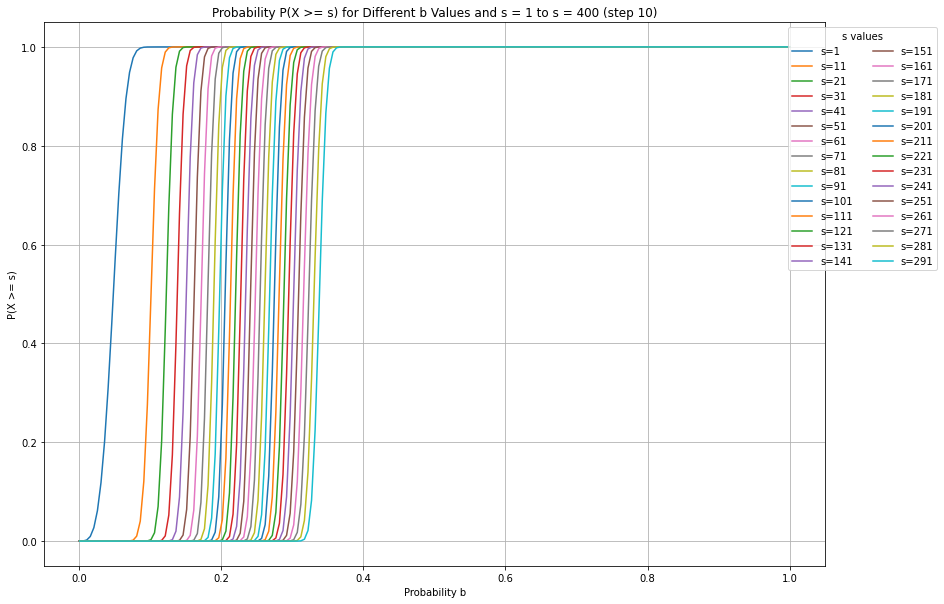

In [7]:
# To optimize the calculation, we'll use a reduced step size for visualization
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Reinitialize parameters after the reset
n = 468  # Number of nodes
m = 3    # Minimum neighbors
l = 6    # Maximum neighbors
k = 6    # Number of steps

# Define a higher resolution for b values
b_values_high_res = np.linspace(0.001, 1, 200)  # Reduced number for optimization

# Update range for s values from 1 to 400
s_values_range_extended_400 = range(1, 300, 10)  # Use a step of 10 for faster processing

# Initialize a dictionary to store probabilities for different s values and b values
probabilities_dict_extended_400 = {}

# Loop through each value of s from 1 to 400 with step size of 10
for s in s_values_range_extended_400:
    probabilities_for_s = []
    
    # Loop through more refined possible values of b
    for b in b_values_high_res:
        # Calculate the average probability that a hub is black
        p = sum([(1 - (1 - b)**k)**(d + 1) for d in range(m, l + 1)]) / (l - m + 1)
        
        # Calculate the probability that at least s hubs are black
        probability_at_least_s_hubs = 1 - binom.cdf(s - 1, n, p)
        
        # Store the probability for the current b value
        probabilities_for_s.append(probability_at_least_s_hubs)
    
    # Store the list of probabilities for the current s in the dictionary
    probabilities_dict_extended_400[s] = probabilities_for_s

# Plotting the probabilities for s = 1 to s = 400 (step of 10) with different b values
plt.figure(figsize=(14, 10))

# Loop to plot each line for s from 1 to 400 with step size of 10
for s in s_values_range_extended_400:
    plt.plot(b_values_high_res, probabilities_dict_extended_400[s], label=f's={s}')

plt.xlabel('Probability b')
plt.ylabel('P(X >= s)')
plt.title('Probability P(X >= s) for Different b Values and s = 1 to s = 400 (step 10)')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='s values', ncol=2)
plt.show()


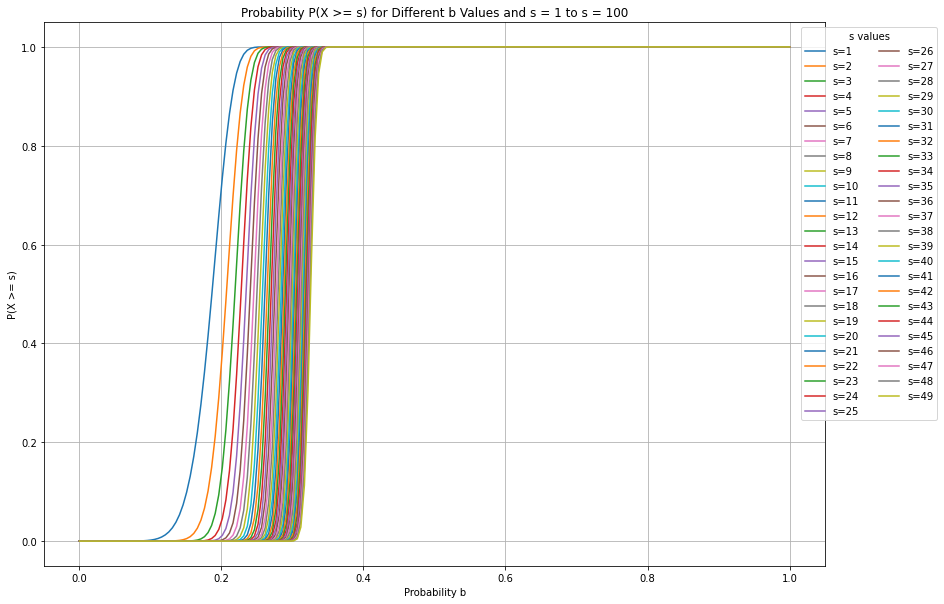

In [9]:
# Re-import necessary libraries due to reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Reinitialize parameters due to reset
n = 468  # Number of nodes
m = 3    # Minimum neighbors
l = 6    # Maximum neighbors
k = 6    # Number of steps

# Define a higher resolution for b values
b_values_high_res = np.linspace(0.001, 1, 200)  # Refined probability values for b

# Update range for s values from 1 to 100
s_values_range_100 = range(1, 50)

# Initialize a dictionary to store probabilities for different s values and b values
probabilities_dict_s100 = {}

# Loop through each value of s from 1 to 100
for s in s_values_range_100:
    probabilities_for_s = []
    
    # Loop through more refined possible values of b
    for b in b_values_high_res:
        # Calculate the average probability that a 2-hop hub is black
        p_2 = 0
        for d_v in range(m, l + 1):
            for d_u in range(m, l + 1):
                p_2 += (1 - (1 - b)**k)**(d_v + 1 + d_u * d_v)
        p_2 /= (l - m + 1)**2
        
        # Calculate the probability that at least s 2-hop hubs are black
        probability_at_least_s_hubs_2 = 1 - binom.cdf(s - 1, n, p_2)
        
        # Store the probability for the current b value
        probabilities_for_s.append(probability_at_least_s_hubs_2)
    
    # Store the list of probabilities for the current s in the dictionary
    probabilities_dict_s100[s] = probabilities_for_s

# Plotting the probabilities for s = 1 to s = 100 with different b values
plt.figure(figsize=(14, 10))

# Loop to plot each line for s from 1 to 100
for s in s_values_range_100:
    plt.plot(b_values_high_res, probabilities_dict_s100[s], label=f's={s}')

plt.xlabel('Probability b')
plt.ylabel('P(X >= s)')
plt.title('Probability P(X >= s) for Different b Values and s = 1 to s = 100')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title='s values', ncol=2)
plt.show()
